In [1]:
import pandas as pd
import re
import os
import torch

In [2]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: NVIDIA GeForce RTX 3090


In [ ]:
csv_path = '/content/drive/My Drive/stacked_arrays_split.csv'

In [ ]:
# Ausgabe-Ordner
output_dir = '/content/drive/My Drive/'
output_suffix = '_final.csv'

# CSV einlesen
df = pd.read_csv(csv_path)

# Spaltennamen vereinheitlichen (nur sicherheitshalber)
df.columns = [c.strip().lower() for c in df.columns]  # → 'output_file', 'split'

# Label berechnen aus Dateinamen
def extract_label_from_filename(name):
    match = re.search(r'class(\d+)', name)
    if match:
        return int(match.group(1)) - 3  # hier wird -3 gemacht
    return None  # falls kein Match

# Neue Spalten hinzufügen
df['filename'] = df['output_file'].apply(lambda x: re.sub(r'class(\d+)', lambda m: f'class{int(m.group(1)) - 3}', x))
df['label'] = df['output_file'].apply(extract_label_from_filename)

# Daten nach Split aufteilen und als separate CSV speichern
for split in ['train', 'val', 'test']:
    df_split = df[df['split'].str.lower() == split][['filename', 'label']]
    out_path = os.path.join(output_dir, f"{split}{output_suffix}")
    df_split.to_csv(out_path, index=False)
    print(f"Gespeichert: {out_path}")

Gespeichert: /content/drive/My Drive/train_final.csv
Gespeichert: /content/drive/My Drive/val_final.csv
Gespeichert: /content/drive/My Drive/test_final.csv


### Create Custom Dataset Class

In [9]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import random
import pandas as pd

class CropDatasetFromCSV(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)  # CSV-Datei lesen, Spalten: filename und label
        self.image_dir = image_dir
        self.transform = transform  # Transform optional, callable
        self.num_classes = self.data['label'].max() + 1    # Maximale Anzahl an Klassen berechnen

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Datei- und Labelnamen aus der CSV lesen
        filename = self.data.iloc[idx]['filename']
        label = self.data.iloc[idx]['label']
        label = torch.tensor(label, dtype=torch.long)

        # Lade das .npy-Bild
        path = os.path.join(self.image_dir, filename)
        array = np.load(path)  # Shape: [Bands, H, W]

        # === Handle NaN/Inf values ===
        array = np.nan_to_num(array, nan=0.0, posinf=0.0, neginf=0.0)

        # Zu Tensor konvertieren
        tensor = torch.tensor(array, dtype=torch.float32)

        # Transformation anwenden, falls definiert
        if self.transform:
            tensor = self.transform(tensor)

        return tensor, label

### Custom Image Transformation Pipeline


In [7]:
import torch.nn.functional as F

class MultiBandTransform:
    def __init__(self, size=224, normalize=False):
        self.size = size
        self.normalize = normalize

    def __call__(self, x):
        # Resize auf 224x224 (bilineare Interpolation, bandweise)
        x = F.interpolate(x.unsqueeze(0), size=(self.size, self.size), mode='bilinear', align_corners=False)
        x = x.squeeze(0)

        # Datenaugmentation (Flip & Rotation)
        if random.random() > 0.5:
            x = TF.hflip(x)  # Horizontal Flip
        if random.random() > 0.5:
            x = TF.vflip(x)  # Vertikal Flip
        if random.random() > 0.5:
            x = TF.rotate(x, angle=90)  # 90° Rotation

        # Optional: Normalisierung pro Band
        if self.normalize:
            # Min-Max-Normalisierung auf [0, 1] je Kanal
            min_vals = x.amin(dim=(1, 2), keepdim=True)
            max_vals = x.amax(dim=(1, 2), keepdim=True)
            x = (x - min_vals) / (max_vals - min_vals + 1e-6)

        return x


### Dataloader

In [10]:
from torch.utils.data import DataLoader

# Pfade
image_dir = '/content/drive/My Drive/stacked_patches2'
train_csv = '/content/drive/My Drive/train_final.csv'
val_csv = '/content/drive/My Drive/val_final.csv'
test_csv = '/content/drive/My Drive/test_final.csv'

# Transformationen definieren
train_transform = MultiBandTransform(size=224, normalize=True)
val_transform = MultiBandTransform(size=224, normalize=True)

# Datasets
train_dataset = CropDatasetFromCSV(train_csv, image_dir, transform=train_transform)
val_dataset = CropDatasetFromCSV(val_csv, image_dir, transform=val_transform)
test_dataset = CropDatasetFromCSV(test_csv, image_dir, transform=val_transform)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

### Visualize Images from DataLoader

In [ ]:
# Get a batch from the train_loader
batch = next(iter(train_loader))
images, labels = batch
print("Batch shape:", images.shape)
print("Batch values (min, max):", images.min().item(), images.max().item())
print("First image values:", images[0])

### Visualize Images Before and After Normalization

In [ ]:
import matplotlib.pyplot as plt

# Load a sample image (as numpy array) from file
sample_filename = train_dataset.data.iloc[0]['filename']
sample_path = os.path.join(train_dataset.image_dir, sample_filename)
sample_array = np.load(sample_path)

# Convert to tensor
sample_tensor = torch.tensor(sample_array, dtype=torch.float32)

# Show original (not normalized)
plt.figure(figsize=(12,4))
for i, band in enumerate([0, 50, 99]):
    plt.subplot(1,3,i+1)
    plt.imshow(sample_tensor[band], cmap='gray')
    plt.title(f'Original Band {band}')
    plt.axis('off')
plt.suptitle('Before Normalization')
plt.show()

# Apply normalization
transform_norm = MultiBandTransform(size=224, normalize=True)
sample_norm = transform_norm(sample_tensor)

plt.figure(figsize=(12,4))
for i, band in enumerate([0, 50, 99]):
    plt.subplot(1,3,i+1)
    plt.imshow(sample_norm[band], cmap='gray')
    plt.title(f'Normalized Band {band}')
    plt.axis('off')
plt.suptitle('After Normalization')
plt.show()

In [ ]:
# Use a transform with augmentation (random flip/rotate, no normalization)
transform_aug = MultiBandTransform(size=224, normalize=False)

# Show original
plt.figure(figsize=(12,4))
for i, band in enumerate([0, 50, 99]):
    plt.subplot(1,3,i+1)
    plt.imshow(sample_tensor[band], cmap='gray')
    plt.title(f'Original Band {band}')
    plt.axis('off')
plt.suptitle('Before Augmentation')
plt.show()

# Apply augmentation
sample_aug = transform_aug(sample_tensor)

plt.figure(figsize=(12,4))
for i, band in enumerate([0, 50, 99]):
    plt.subplot(1,3,i+1)
    plt.imshow(sample_aug[band], cmap='gray')
    plt.title(f'Augmented Band {band}')
    plt.axis('off')
plt.suptitle('After Augmentation')
plt.show()


In [11]:
"""Edited-code(Mohamed)"""

import torch
import torch.nn as nn
from torchvision.models import resnet50

class CustomResNet50(nn.Module):
    def __init__(self, in_channels=100, num_classes=5):
        super().__init__()

        # Load standard ResNet-50
        self.model = resnet50(weights=None)  # or pretrained=True if you want pretrained weights

        # Replace the first convolutional layer
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the fully connected (classification) layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Instantiate and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomResNet50(in_channels=100, num_classes=5).to(device)


### Tests vor dem Training

In [12]:
# Einen Batch laden und Infos anzeigen
batch = next(iter(train_loader))
images, labels = batch

print("Image batch shape:", images.shape)  # [16, 110, 224, 224]
print("Label batch shape:", labels.shape)
print("Beispiel-Label:", labels[0])


Image batch shape: torch.Size([16, 100, 224, 224])
Label batch shape: torch.Size([16])
Beispiel-Label: tensor(0)


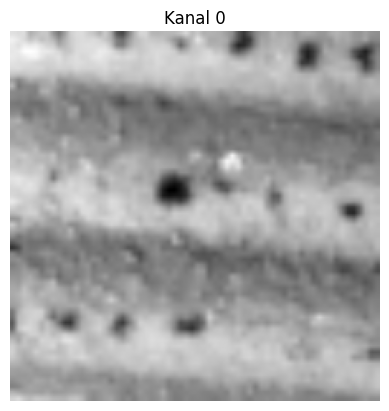

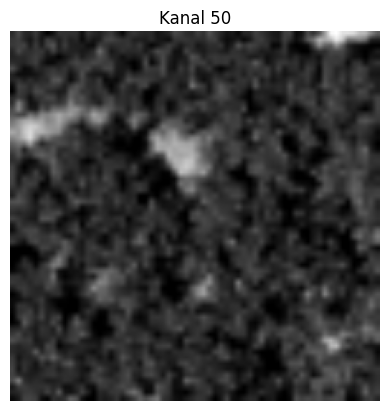

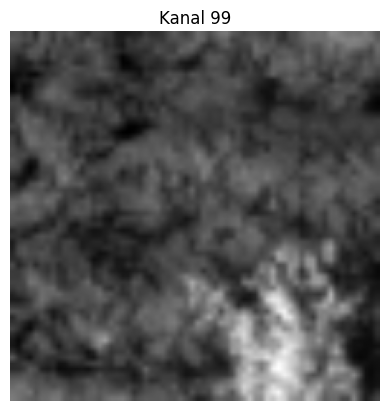

In [13]:
import matplotlib.pyplot as plt

# 1 Bild, 3 Kanäle anzeigen (z. B. Kanal 0, 50, 99)
img = images[0]

for i in [0, 50, 99]: # Changed 100 to 99 to be within bounds
    plt.imshow(img[i].cpu().numpy(), cmap='gray')
    plt.title(f"Kanal {i}")
    plt.axis('off')
    plt.show()

In [14]:
# Dummy-Test (Vorwärtsdurchlauf ohne Training)
model.eval()
with torch.no_grad():
    images = images.to(device)
    labels = labels.to(device) # Ensure labels are on GPU (though not used in model(images))
    out = model(images)  # Shape: [16, 8]
    print("Model output shape:", out.shape)
    print("Output (erste 2 Beispiele):\n", out[:2])


Model output shape: torch.Size([16, 5])
Output (erste 2 Beispiele):
 tensor([[-2.8664, -3.0364, -6.4750,  3.1535,  4.3167],
        [-3.4815, -3.7819, -7.7808,  3.1544,  4.8335]], device='cuda:0')


In [15]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

model.train()
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print("Batch Loss:", loss.item())
    break  # Nur 1 Batch zum Testen


Batch Loss: 1.6620486974716187


### Training Loop


In [ ]:
torch.isnan(batch).any(), torch.isinf(batch).any()

In [ ]:
"""Edited-code (Mohamed)"""


def training_settings(model, epochs, device, optimizer,
                      criterion, train_dataloader, val_dataloader, weights_name,
                      ):
    """
    This function trains a PyTorch model for a specified number of epochs, and evaluates it on a validation set.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        epochs (int): The number of epochs to train the model.
        device (str): The device (cpu or cuda) where the model and data are to be loaded.
        optimizer (torch.optim.Optimizer): The optimization algorithm used to update the model parameters.
        criterion (torch.nn.modules.loss._Loss): The loss function used to evaluate the model.
        train_dataloader (torch.utils.data.DataLoader): The DataLoader for the training data.
        val_dataloader (torch.utils.data.DataLoader): The DataLoader for the validation data.

    Returns:
        tuple: A tuple containing four lists. The first list contains the training losses for each epoch,
               the second list contains the validation losses for each epoch,
               the third list contains the training accuracies for each epoch,
               and the fourth list contains the validation accuracies for each epoch.
    """
    train_losses = []
    val_losses = []

    trn_accuracy = []
    val_accuracy = []

    for epoch in range(epochs):
        # Training from scratch

        model.train()


        train_loss = 0.0
        train_correct = 0

        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)
            # Compute loss

            loss = criterion(outputs, labels.long())
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update training loss
            train_loss += loss.item()
            # Count number of correct predictions
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()

        # Compute average training loss and accuracy
        train_loss /= len(train_dataloader)
        train_accuracy = 100.0 * train_correct / len(train_dataloader.dataset)
        # print(train_accuracy)
        train_losses.append(train_loss)
        trn_accuracy.append(train_accuracy)

        # Validation
        model.eval()
        valid_loss = 0.0
        valid_correct = 0

        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                # Compute loss
                loss = criterion(outputs, labels.long())

                # Update validation loss
                valid_loss += loss.item()
                # Count number of correct predictions
                _, predicted = torch.max(outputs.data, 1)
                valid_correct += (predicted == labels).sum().item()

        # Compute average validation loss and accuracy
        valid_loss /= len(val_dataloader)
        valid_accuracy = 100.0 * valid_correct / len(val_dataloader.dataset)
        # print(valid_accuracy)
        val_losses.append(valid_loss)
        val_accuracy.append(valid_accuracy)

        # Print progress
        print(f"Epoch [{epoch+1}/{epochs}], "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
            f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")
        print('1')
        # Check for early stopping
        # Check for early stopping

        torch.save(model.state_dict(), weights_name + f'_{epoch}'+'.pt')

    return train_losses, val_losses, trn_accuracy, val_accuracy



model_weights_name = 'lena_model'

device = 'cuda'
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

epochs = 15
device = 'cuda'
early_stop_flag = True


train_losses, val_losses, _, _ = training_settings(model = model, epochs = epochs, device = device,
                  optimizer=optimizer, criterion=criterion,
                  train_dataloader= train_loader, val_dataloader= val_loader, weights_name= model_weights_name,
                  )

Epoch [1/500], Train Loss: 0.7588, Train Accuracy: 70.49%, Valid Loss: 7.0183, Valid Accuracy: 36.56%
1
Epoch [2/500], Train Loss: 0.2586, Train Accuracy: 91.54%, Valid Loss: 1.0012, Valid Accuracy: 66.25%
1
Epoch [3/500], Train Loss: 0.1758, Train Accuracy: 94.21%, Valid Loss: 0.1860, Valid Accuracy: 94.71%
1
Epoch [4/500], Train Loss: 0.1570, Train Accuracy: 95.16%, Valid Loss: 0.0682, Valid Accuracy: 97.64%
1
